# Medical Report generation from Chest X-Ray Using Deep Learning 

## Business Problem 

## Description :

If you visit a doctor with chest pain , breathing issues or regular medical checkup you will be asked to get a Chest X-Ray . Radiolgists examines the chest X-Ray and gets to a conculsion of normality or Abnormalities and further medication and describes the chest X-Ray in verbal form. The problem with today’s diagnostics is medical report errors where increasing day by day due to lack of experienced radiologists. These Medical report errors will be dangerous and can put human’s life in risk by incorrect diagnostics and medications.

In this case study we are aiming at generating the medical report from chest X-Ray images which describes the medical image.

## Metric : 

As we are generating a sequence of words as our output. 

Bilingual Evaluation Understudy Score(BLEU) is used as a metric for evaluating a generated output to actual output(expected output). A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
This metric is most commonly used in sequence model like Machine translation system, image captioning ,speech text detection.

## Bussiness Constraints : 

No Strict Latency Constraints.

Interpretability is partially important.

Need Precise Report and cost of wrong report is high.


## Dataset : 

The dataset consists of 2 folders . One corresponds to X-Ray images and other corresponds to the XML files which contains the medical reports of single patient. 

There are in total 3955(XML files) Radiology reports and 7470 Chest X-Ray images . Each XML file may corresponds to one or more than one image .The X_Ray images are in PNG formate . 

The dataset is made publicly available by Indiana University . 

One can download the required Dataset from here: 
[XML Reports](http://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9) , 
[X-Ray images](http://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d)



In [ ]:
#remove warnings from displaying in output 
import warnings 
warnings.filterwarnings('ignore')

# importing the required libraries 
import os 
import re 
import nltk
import cv2
nltk.download('stopwords')
nltk.download('punkt')
from bs4 import BeautifulSoup
from PIL import Image
from skimage.transform import resize
from nltk.corpus import stopwords
from nltk import word_tokenize
from os import listdir
from os import path
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud, ImageColorGenerator
import xml.etree.ElementTree as ET

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Extracting the required fields from xml file

def extract_text_from_xml():
    
    '''
    Extracting the required fields from XML files 
    '''

    xml_directory = '/content/drive/My Drive/ecgen-radiology'

    indication_list=[]
    finding_list=[]
    impression_list=[]
    image_list=[]

    for file in tqdm(os.listdir(xml_directory)):
        f=os.path.join(xml_directory,file)
    
        if file.endswith(".xml"):
            # parsing the xml file     
            tree=ET.parse(f)

            #Extracting the required elements of xml tree
            indication=tree.find(".//AbstractText[@Label='INDICATION']").text
            finding = tree.find(".//AbstractText[@Label='FINDINGS']").text
            impression = tree.find(".//AbstractText[@Label='IMPRESSION']").text

            #stroing it into a list 
            indication_list.append(indication)
            finding_list.append(finding)
            impression_list.append(impression)
        
            #since each xml may contain more than one images to store image names in a set 
            image=set()
            #extracting the images id from the xml file 
            for img in tree.findall("parentImage"):
                img_list = img.attrib['id']+".png"
                image.add(img_list)

        #appending all the images and storing it in a list 
        image_list.append(",".join(image))
    return image_list , impression_list , finding_list , indication_list

In [ ]:
#calling the function to extract the reqiured fields from XML files

image_list , impression_list , finding_list , indication_list = extract_text_from_xml()

# constructing a data Frame 
df=pd.DataFrame()
df['images']=image_list
df['impression']=impression_list
df['finding']=finding_list
df['indication']=indication_list

#saving the dataframe to disk 
df.to_csv("/content/drive/My Drive/xml_data.csv",index=False)

100%|██████████| 3955/3955 [22:37<00:00,  2.91it/s]


In [ ]:
del(image_list)
del(impression_list)
del(finding_list)
del(indication_list)

In [ ]:
# loading the extracted data from disk
df=pd.read_csv('/content/drive/My Drive/xml_data.csv')

In [ ]:
#printing the sample points from the dataframe
df.head()

,images,impression,finding,indication
0,"CXR58_IM-2177-2001.png,CXR58_IM-2177-1001.png",No acute disease.,The heart is normal in size. The mediastinum i...,Left arm numbness
1,"CXR575_IM-2173-2001.png,CXR575_IM-2173-1001.png",No acute cardiopulmonary abnormalities.,The heart size and mediastinal silhouette are ...,XXXX-year-old male with XXXX and hypertension.
2,"CXR600_IM-2192-2001.png,CXR600_IM-2192-1001.png",Negative for acute abnormality.,The cardiomediastinal silhouette is normal in ...,XXXX-year-old male. Shortness of breath. Synco...
3,NaN,No acute cardiopulmonary abnormality.,Cardiac silhouette is unchanged. Aorta is calc...,UTI.
4,"CXR587_IM-2182-1001.png,CXR587_IM-2182-3001.pn...",1. No interval change in the appearance of the...,The cardiomediastinal silhouette is within nor...,XXXX-year-old male suspected pneumonia.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3955 entries, 0 to 3954
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   images      3851 non-null   object
 1   impression  3921 non-null   object
 2   finding     3425 non-null   object
 3   indication  3865 non-null   object
dtypes: object(4)
memory usage: 123.7+ KB


#### Observation:

From the above observation we can say that there are in total 3851 datapoints which contains atleast one image . 

There are 104 datapoints which do not contain any images . 

There are 3921 datapoints which contains impressions and 34 datapoints which does not contain impressions(target) . 

There are 3425 datapoins which contains findings and 530 datapoints with no findings . 

Out of 3955 datapoints 90 datapoints do not contain any indication . 

In [ ]:
#dropping all the datapoints with no images 

df.dropna(0,subset=['images'],inplace=True)
df = df.reset_index(drop=True)

In [ ]:
#filling NAN values in a each of the columns 

df['indication']=df['indication'].fillna('No Indication')
df['finding']=df['finding'].fillna('No Findings')
df['impression']=df['impression'].fillna('No Impression')

#### Preproceesing text columns of the dataframes 

In [ ]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess(text):
  text = re.sub('XXXX','',text)
  text=re.sub(r'[^A-Za-z]+',' ',text)
  text = decontracted(text)
  text = re.sub('\\r', ' ',text)
  text = re.sub('\\n', ' ',text)
  return text

In [ ]:
df['indication'] = df['indication'].apply(lambda x : preprocess(x)) 
df['finding'] = df['finding'].apply(lambda x : preprocess(x)) 
df['impression'] = df['impression'].apply(lambda x : preprocess(x)) 

In [ ]:
df.head()

,images,impression,finding,indication
0,"CXR58_IM-2177-2001.png,CXR58_IM-2177-1001.png",No acute disease,The heart is normal in size The mediastinum is...,Left arm numbness
1,"CXR575_IM-2173-2001.png,CXR575_IM-2173-1001.png",No acute cardiopulmonary abnormalities,The heart size and mediastinal silhouette are ...,year old male with and hypertension
2,"CXR600_IM-2192-2001.png,CXR600_IM-2192-1001.png",Negative for acute abnormality,The cardiomediastinal silhouette is normal in ...,year old male Shortness of breath Syncope Sei...
3,"CXR587_IM-2182-1001.png,CXR587_IM-2182-3001.pn...",No interval change in the appearance of the o...,The cardiomediastinal silhouette is within nor...,year old male suspected pneumonia
4,"CXR604_IM-2193-2001.png,CXR604_IM-2193-1001.png",No evidence of active disease,The heart size and pulmonary vascularity appea...,Bone marrow transplant evaluation AML


### Analyzing the Text Columns 

#### Analyzing Indication column

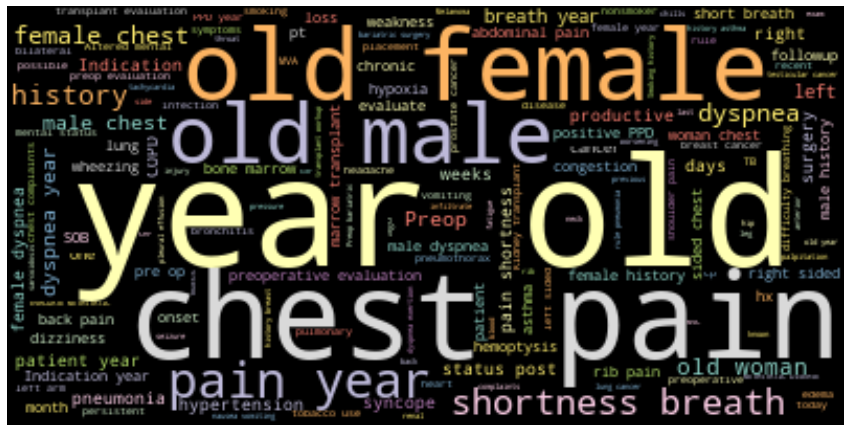

In [ ]:
# medium blogs 
# plotting the top 1000 words in indication column
wordcloud = WordCloud(max_words=1000,colormap='Set3',background_color="black").generate(' '.join(df['indication'].map(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

#### Observation : 

In the indication text column some of the highest occuring words are Chest Pain,old Female,old male,dyspnea,shortness breath ,pain year,year old .

In [ ]:
df['indication_count']=df['indication'].map(str).apply(lambda x:len(x.split()))

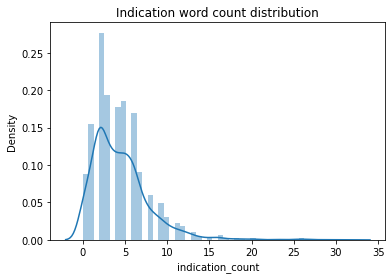

In [ ]:
sns.distplot(df['indication_count'])
plt.title("Indication word count distribution")
plt.show()

In [ ]:
df['indication_count'].describe()

count    3851.000000
mean        4.502727
std         3.540589
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        32.000000
Name: indication_count, dtype: float64

#### Observation : 

From the above plot of number of words in each indication. The mean of the number of words is 4.5 words and median is 4 words and maximum length of indication is 32 words . 

In [ ]:
print("No. of unique indication Report in the Dataset : {}".format(len(df['indication'].unique())))
print("No. of indication report repeated more than one times : {}".format(np.sum(df['indication'].value_counts()>1)))

No. of unique indication Report in the Dataset : 2287
No. of indication report repeated more than one times : 228


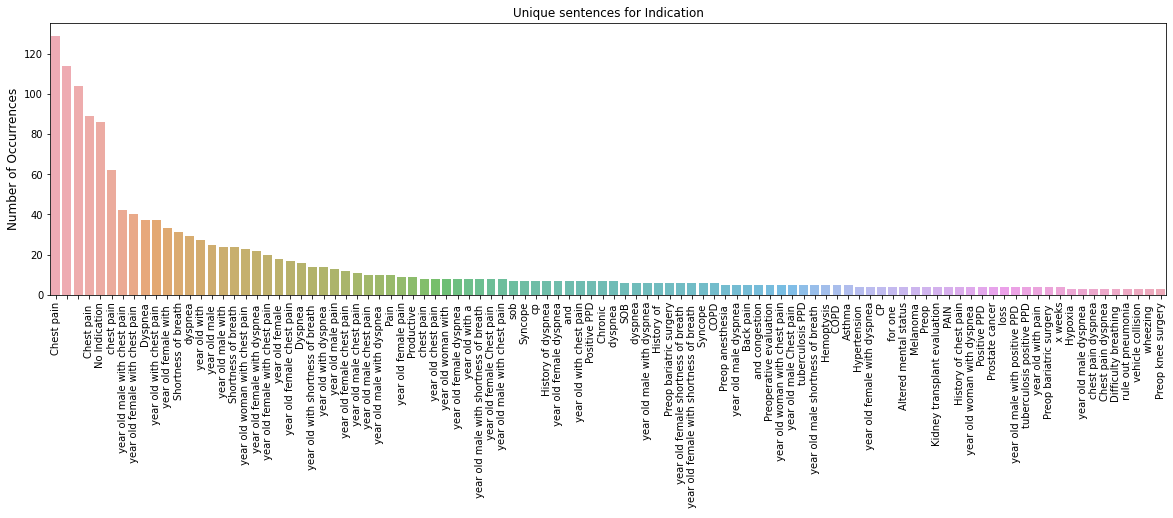

In [ ]:
indication = df.indication.value_counts()[:100]
plt.figure(figsize=(20,5))
sns.barplot(indication.index, indication.values, alpha=0.8)
plt.title("Unique sentences for Indication")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Observation : 
The number of unique indications is 2287 and number of indication repeated more than one times is 228.

'Chest pain' is the most highly occuring sentence in indication column. 

#### Analyzing Finding column

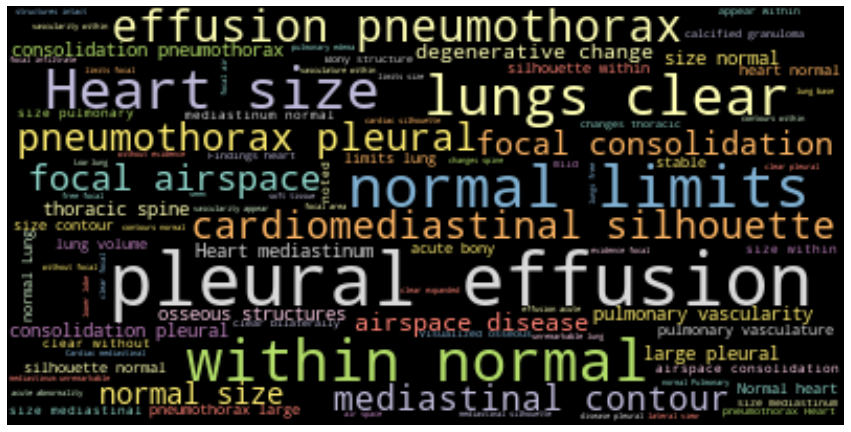

In [ ]:
# plotting the top 1000 words in finding column
wordcloud = WordCloud(max_words=1000,colormap='Set3',background_color="black").generate(' '.join(df['finding'].map(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

#### Observation : 
From the above word cloud plot we can say that in finding column the most frequently occuring words are pleural effusion,normal limits , within normal,hear size, lungs clear.

In [ ]:
df['finding_count']=df['finding'].map(str).apply(lambda x : len(x.split()))

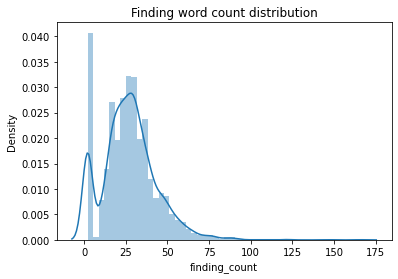

In [ ]:
sns.distplot(df['finding_count'])
plt.title("Finding word count distribution")
plt.show()

In [ ]:
df['finding_count'].describe()

count    3851.000000
mean       26.946507
std        16.353172
min         2.000000
25%        17.000000
50%        26.000000
75%        35.000000
max       166.000000
Name: finding_count, dtype: float64

#### Observation : 
The median number of words per finding is 19 and mean is also around 19 . 

And the max length of finding sentence is 103 . 

In [ ]:
print("No. of unique finding Report in the Dataset : {}".format(len(df['finding'].unique())))
print("No. of finding report repeated more than one times : {}".format(np.sum(df['finding'].value_counts()>1)))

No. of unique finding Report in the Dataset : 2547
No. of finding report repeated more than one times : 140


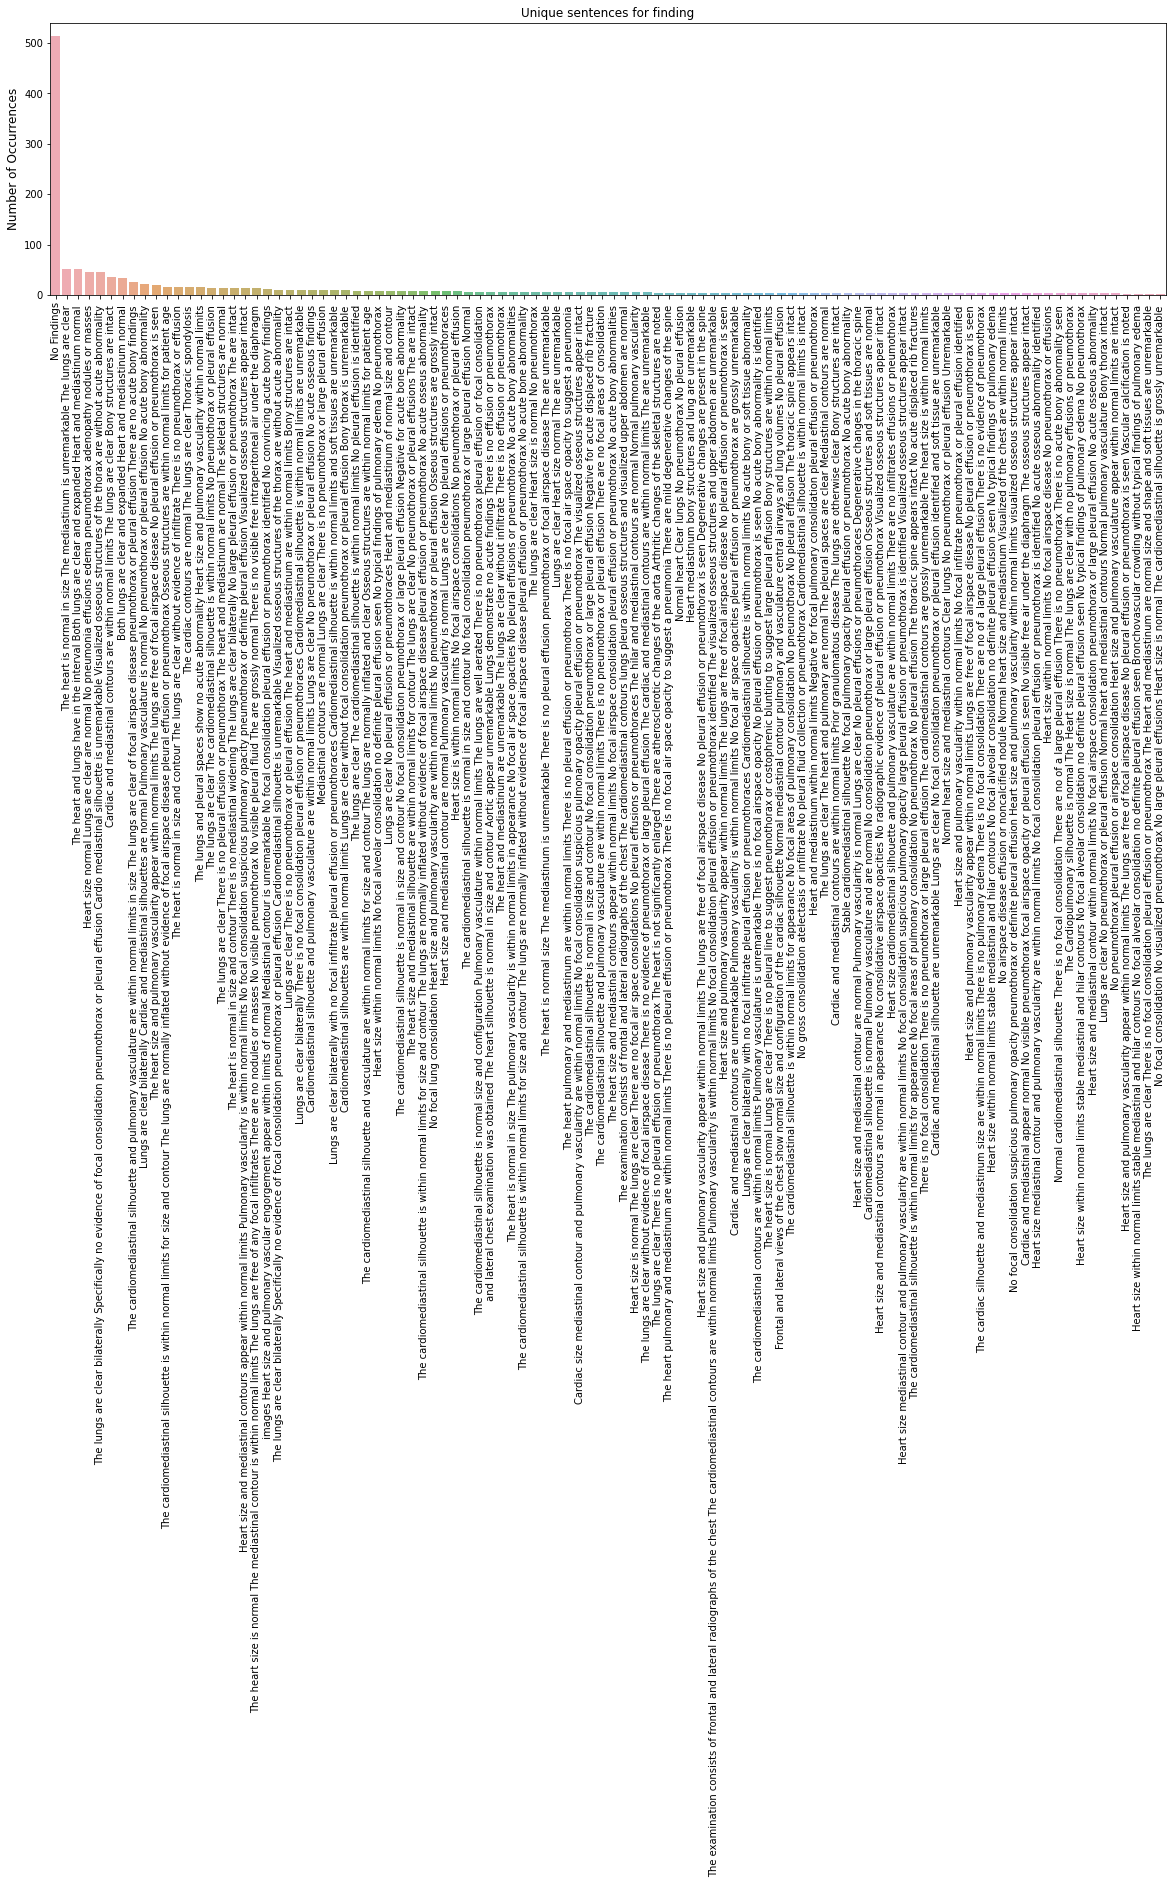

In [ ]:
finding = df.finding.value_counts()[:100]
plt.figure(figsize=(20,5))
sns.barplot(finding.index, finding.values, alpha=0.8)
plt.title("Unique sentences for finding")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Observation : 
As findings column contains more number of NAN values and we replaced NAN values with 'no findings' . we obtain 'no finding' as most occuring finding sentence . 

The number of unique sentence in findings is 2598 and 150 findings occurs more than 1 time .

#### Analyzing Impression column

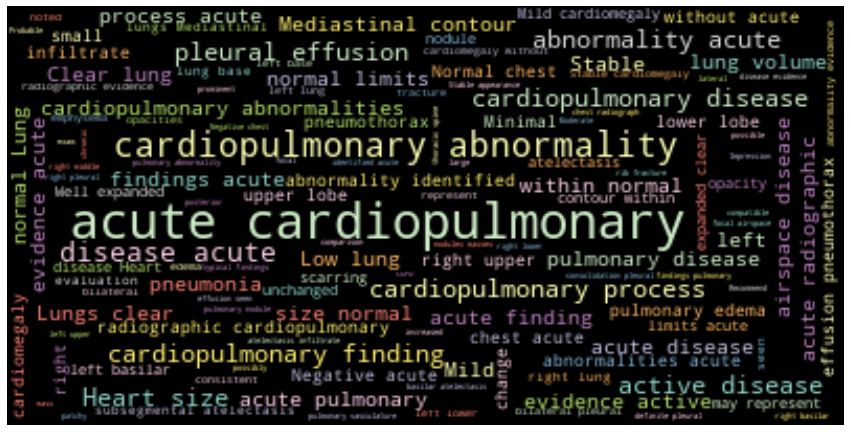

In [ ]:
# plotting the top 1000 words in impression column 
wordcloud = WordCloud(max_words=1000,colormap='Set3',background_color="black").generate(' '.join(df['impression'].map(str)))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='Bilinear')
plt.axis("off")
plt.show()

#### Observation : 

From the above word cloud we can say that acute cardiopulmonary , cardiopulmonary abnormality , disease acute are the most frequently words in the impression (target column) . 


In [ ]:
df['impression_count'] = df['impression'].map(str).apply(lambda x:len(x.split()))

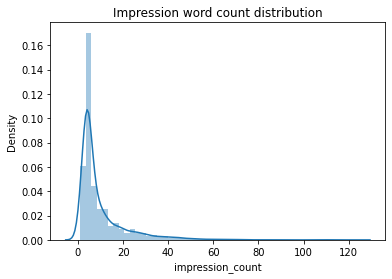

In [ ]:
sns.distplot(df['impression_count'])
plt.title("Impression word count distribution")
plt.show()

In [ ]:
df['impression_count'].describe()

count    3851.000000
mean        9.856920
std        11.198865
min         1.000000
25%         4.000000
50%         5.000000
75%        11.000000
max       123.000000
Name: impression_count, dtype: float64

#### Observation : 

From the above plot we can observe the mean length of impression sentence is 8, median is 4 words . 

And the maximum length of the impression sentence is 85.

In [ ]:
print("No. of unique impression Report in the Dataset : {}".format(len(df['impression'].unique())))
print("No. of impression report repeated more than one times : {}".format(np.sum(df['impression'].value_counts()>1)))

No. of unique impression Report in the Dataset : 1742
No. of impression report repeated more than one times : 134


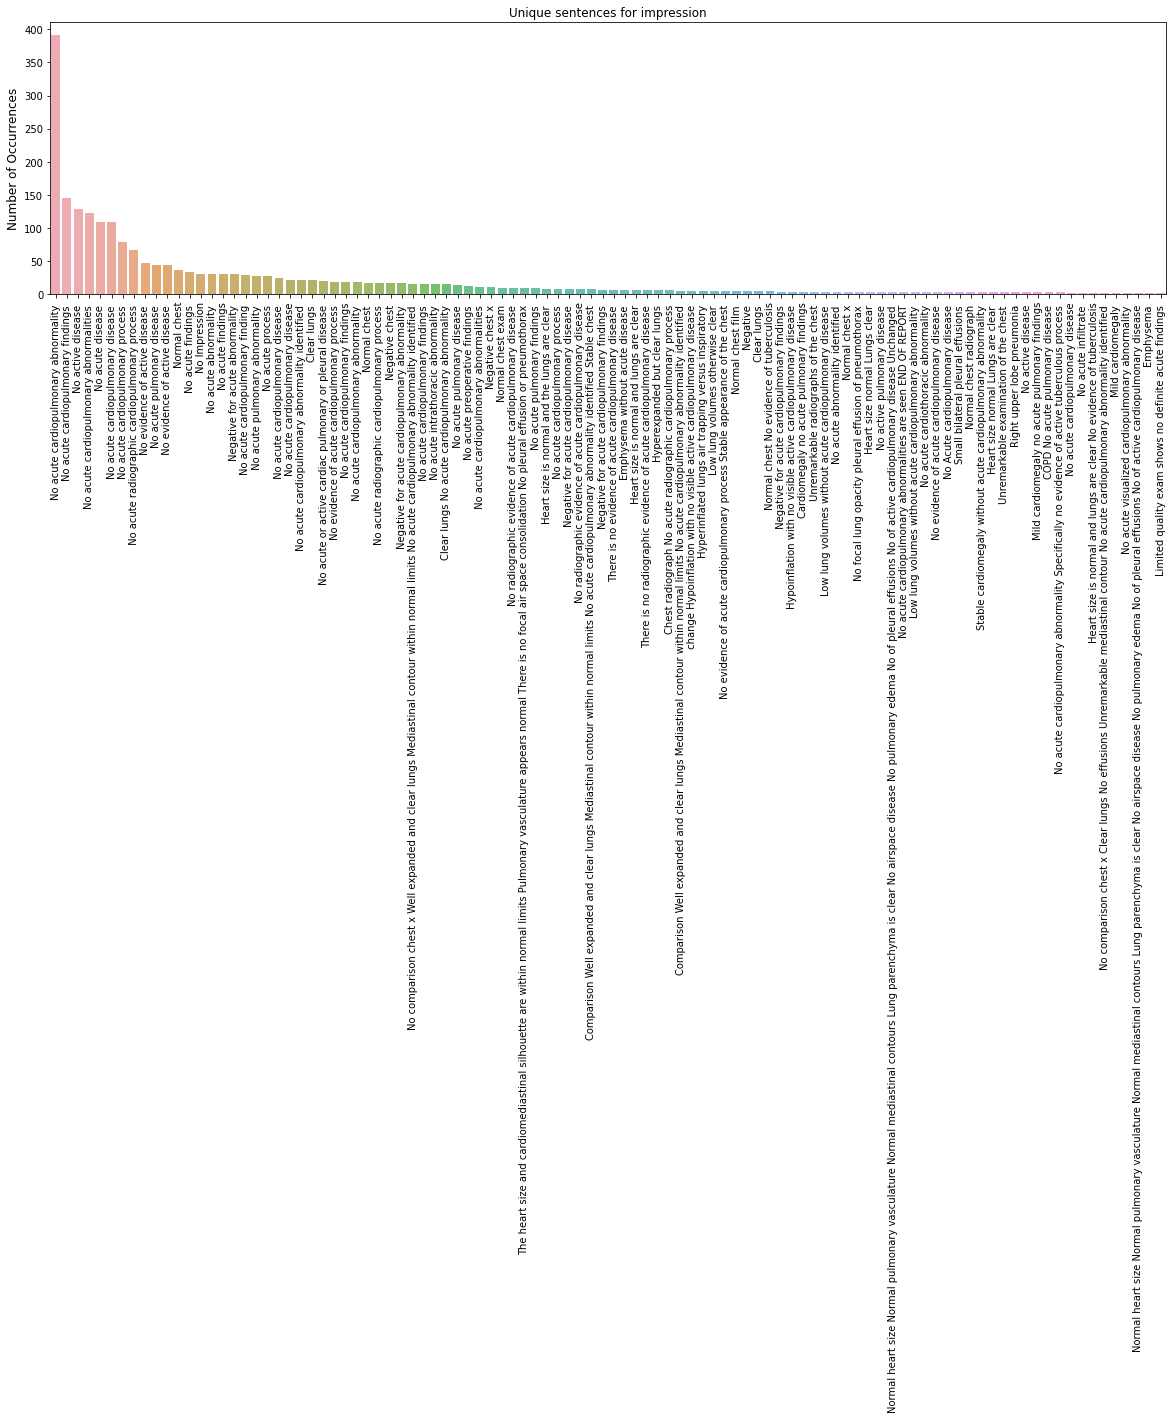

In [ ]:
impression = df.impression.value_counts()[:100]
plt.figure(figsize=(20,5))
sns.barplot(impression.index, impression.values, alpha=0.8)
plt.title("Unique sentences for impression")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=90)
plt.show()

#### Observation : 
The number of unique impressions is 1742 and number of impressions repeated more than one times is 119.

'no acute cardiopulmonary abnormality' is the most highly occuring sentence in impression column. 

### Analyzing the number of images for datapoint 

In [ ]:
#dropping all the datapoints with no images 

df.dropna(0,subset=['images'],inplace=True)

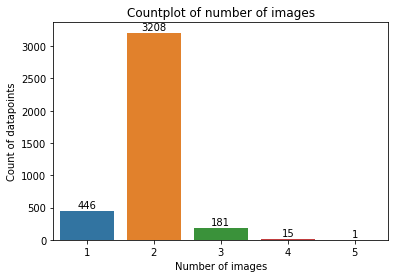

In [ ]:
#finding the number of images each datapoint contains 
images_count = df['images'].apply(lambda x : len(str(x).split(',')))

x_label = list(images_count.value_counts().to_dict().keys())
y_label = list(images_count.value_counts().to_dict().values())

g = sns.barplot(x=x_label,y=y_label)

for i in range(len(x_label)):
    g.text(x_label[i]-1,y_label[i]+40, y_label[i], color='black', ha="center")

plt.xlabel('Number of images')
plt.ylabel('Count of datapoints')
plt.title('Countplot of number of images')
plt.show()

#### observation:

From the above plot we can conclude that after removing the datapoints without images . We are left with datapoints containing distinct number of images . 

446 datapoints contain only single image 

3208 datapoints contains 2 images (frontal and lateral)

181 datapoints contains 3 images (we need to generate the datapoints from this in such a way each datapoint contains 2 images).

15 datapoints contains 4 images. 

And there is only 1 datapoint which contains 5 images . 

## Analyzing the dimensions(height and width) of the images.



In [ ]:
# https://stackoverflow.com/questions/6444548/how-do-i-get-the-picture-size-with-pil
width = []
height = []

for image in tqdm(os.listdir('/content/drive/MyDrive/NLMCXR_png')):
    im = Image.open('/content/drive/MyDrive/NLMCXR_png/'+image)
    w, h = im.size
    
    width.append(w)
    height.append(h)

100%|██████████| 7470/7470 [1:15:56<00:00,  1.64it/s]


In [ ]:
np.median(widths)

512.0

In [ ]:
np.median(heights)

512.0

#### Observation: 

we can observe that the width of the all the images is common (512) but the height varies from image to image but the median of the heights is 512 .

#### Analyzing the quality of the image by using file size .

In [ ]:
#https://www.geeksforgeeks.org/python-os-stat-method/

files = os.listdir('/content/drive/MyDrive/NLMCXR_png')

sizebytes=[]
fnames=[]

for file in files:
    statinfo=os.stat('/content/drive/MyDrive/NLMCXR_png/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    # converting into KB's
    sizebytes.append(statinfo.st_size/(1024.0))
    fnames.append(file)

image_size_df=pd.DataFrame({'Image':fnames,'size':sizebytes})
print(image_size_df.head())

                  Image        size
0   CXR439_IM-2078-1001  202.710938
1  CXR3321_IM-1588-2001  187.486328
2   CXR754_IM-2306-1001  191.275391
3  CXR2110_IM-0741-2001  149.279297
4   CXR467_IM-2095-2001  217.658203


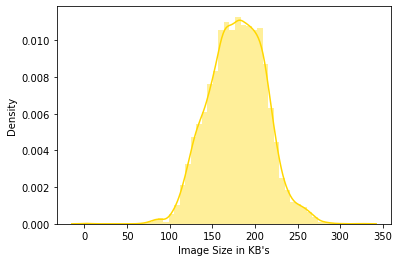

In [ ]:
sns.distplot(image_size_df['size'].values , color="gold")
plt.xlabel('Image Size in KB\'s')
plt.show()

In [ ]:
image_size_df['size'].describe()

count    7470.000000
mean      179.043788
std        33.129864
min         1.864258
25%       156.327393
50%       179.754395
75%       202.690674
max       325.591797
Name: size, dtype: float64

#### Observation : 

The mean size of the images is 179 KB and median is also 179 KB. The size of the image varies from image to image but the median and mean of the image size is 179 KB's . 

## Obtaining 2 images per datapoint

In [ ]:
# selecting only required columns from dataframe
df = df[['images','impression']]

In [ ]:
column_names=['image1','image2','impression']

final_df = pd.DataFrame(columns=column_names)

for index,row in df.iterrows():

    no_images= row['images'].split(',')
    
    if(len(no_images)>2):
        front_view = no_images[:-1]
        lateral_view = no_images[-1]
        for i in range(len(front_view)):
            image_1 = front_view[i]
            image_2 = lateral_view
            final_df = final_df.append(pd.Series([image_1, image_2, row['impression']],index=column_names), ignore_index = True)

    elif(len(no_images)==2):
        front_view = no_images[0]
        lateral_view = no_images[1]
        final_df = final_df.append(pd.Series([front_view, lateral_view, row['impression']],index=column_names), ignore_index = True)

    elif(len(no_images)==1):
        front_view = no_images[0]
        lateral_view = no_images[0]
        final_df = final_df.append(pd.Series([front_view, lateral_view, row['impression']],index=column_names), ignore_index = True)


We are forming dataset in such a way that every data point contains 2 images (one frontal view and one lateral view).

if it contains only single image : 
    replicate the image twice 

if it contains 2 images : 
    no need to perform any transformation 

if it contains 3 images : 
    1st image + 2nd image 
    1st image + 3rd image 

if it contain 4 images : 
    1st image + 2nd image 
    1st image + 3rd image 
    1st image + 4th image 

if it contain 5 images : 
    1st image + 2nd image 
    1st image + 3rd image
    1st image + 4th image 
    1st image + 5th image 


In [ ]:
final_df.head()

,image1,image2,impression
0,CXR58_IM-2177-2001.png,CXR58_IM-2177-1001.png,No acute disease
1,CXR575_IM-2173-2001.png,CXR575_IM-2173-1001.png,No acute cardiopulmonary abnormalities
2,CXR600_IM-2192-2001.png,CXR600_IM-2192-1001.png,Negative for acute abnormality
3,CXR587_IM-2182-1001.png,CXR587_IM-2182-2001.png,No interval change in the appearance of the o...
4,CXR587_IM-2182-3001.png,CXR587_IM-2182-2001.png,No interval change in the appearance of the o...


In [ ]:
final_df['images']=final_df['image1']+','+final_df['image2']

In [ ]:
final_df[['images','impression']].to_csv('/content/drive/MyDrive/final_df.csv',index=False)

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/final_df.csv')
final_df.head()

,images,impression
0,"CXR58_IM-2177-2001.png,CXR58_IM-2177-1001.png",No acute disease
1,"CXR575_IM-2173-2001.png,CXR575_IM-2173-1001.png",No acute cardiopulmonary abnormalities
2,"CXR600_IM-2192-2001.png,CXR600_IM-2192-1001.png",Negative for acute abnormality
3,"CXR587_IM-2182-1001.png,CXR587_IM-2182-2001.png",No interval change in the appearance of the o...
4,"CXR587_IM-2182-3001.png,CXR587_IM-2182-2001.png",No interval change in the appearance of the o...


#### checking if all the images refered in XML file are present in images or not 

In [ ]:
images = set()
for image in final_df['image1'].values:
    images.add(image)
for image in final_df['image2'].values:
    images.add(image)

images = list(images)

l=0
for image in images:
    if(image not in files):
        l+=1
if(l==0):
    print('All the images referred in xml files are found in images provided.')
else:
    print('All the images referred in xml files are not found in images provided.')  

All the images referred in xml files are found in images provided.


All the images associated with the XML files are present in the images folder(data provided).

## Plotting random datapoint images.

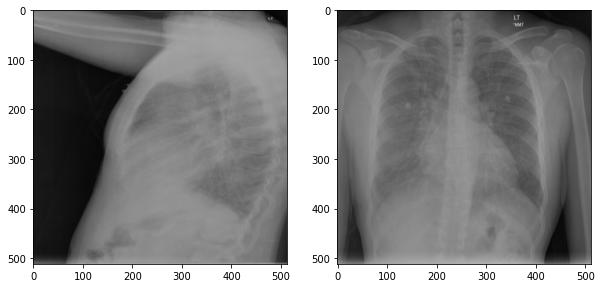

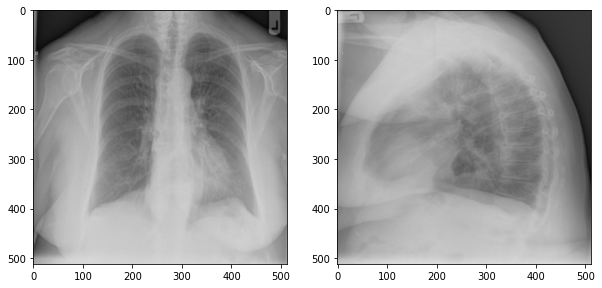

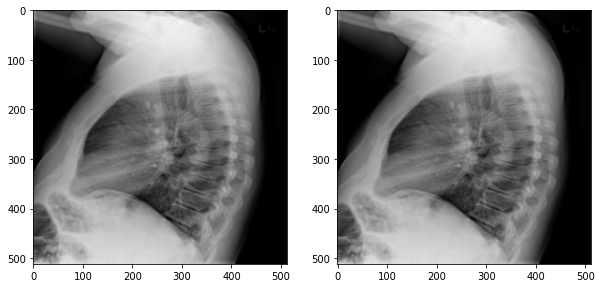

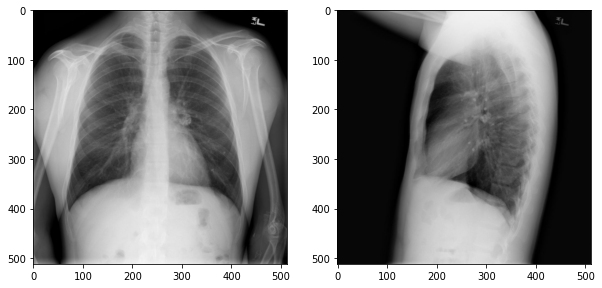

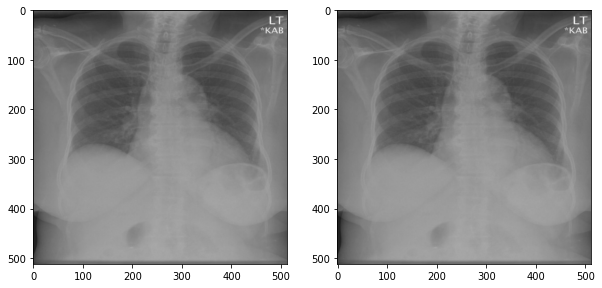

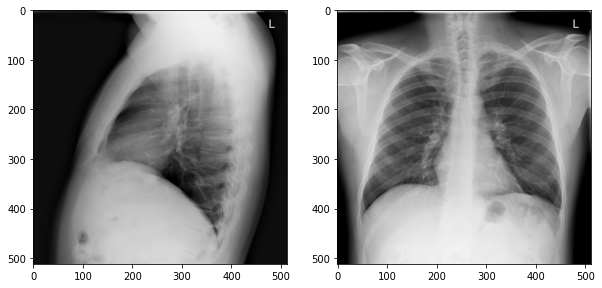

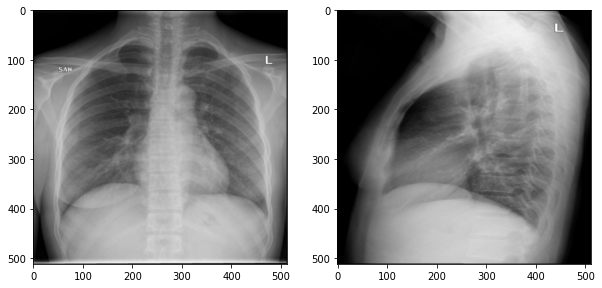

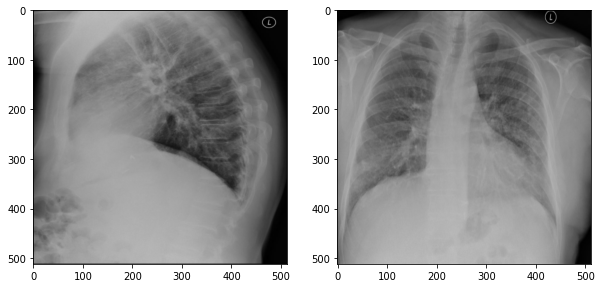

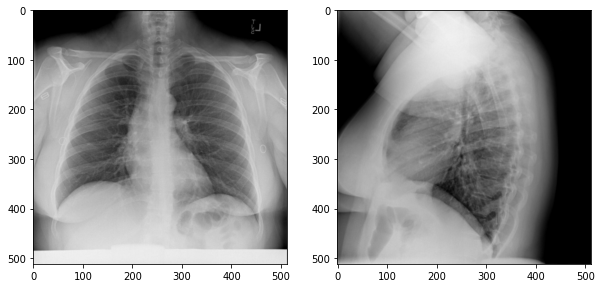

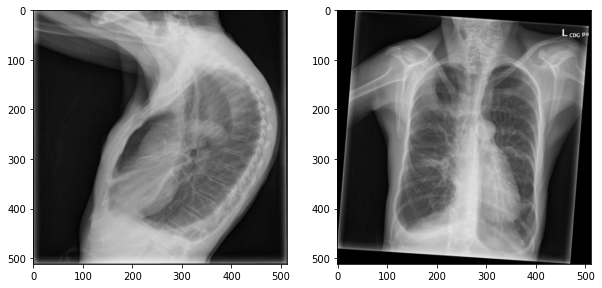

In [ ]:
import random
for i in range(10):
    num = random.randint(0, len(final_df)-1) 
    fr_view = cv2.imread('/content/drive/MyDrive/NLMCXR_png/'+str(final_df['image1'][num]),cv2.IMREAD_UNCHANGED)
    fr_view = cv2.resize(fr_view,(512,512))

    la_view = cv2.imread('/content/drive/MyDrive/NLMCXR_png/'+str(final_df['image2'][num]),cv2.IMREAD_UNCHANGED)
    la_view = cv2.resize(la_view,(512,512))

    plt.figure(figsize=(10,6))  
    plt.subplot(121)
    plt.imshow(fr_view)
    plt.subplot(122)
    plt.imshow(la_view)
    plt.show()

## Transfer Learning using chexNet to extract image features . 

CheXNet is a 121-layer convolution neural network trained on ChestX-ray14 which cotains 100000 frontal view X-Ray images to classify it into 14 diseases. 
We are using the CheXNet to extract image features from the X-Ray images. We are not Training the CheXNet from Scratch we are loading the weights of pretrained model. That is we are performing Transfer Learning .

One can Read more about ChexNet [here](https://arxiv.org/pdf/1711.05225.pdf)

In [ ]:
final_df['impression'] = final_df['impression'].apply(lambda x : '<start> ' + str(x.strip()) + ' <end>' )

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import densenet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import LSTM,Embedding,Dense

In [ ]:
img_width = 224
img_height = 224

In [ ]:
#https://github.com/brucechou1983/CheXNet-Keras
# weigths : https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view 

model = tf.keras.applications.DenseNet121(weights=None,classes = 14,input_shape=(int(img_width),int(img_height),3))

# classes is 14 because its trained on 14 classes classification (multi class classification)
model.load_weights('/content/drive/My Drive/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

image_features_model = Model(inputs=model.input,outputs=model.layers[-2].output)